# Importar librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

%matplotlib inline

## Cargamos el archivo

In [2]:
df = pd.read_csv("vehicle_prices.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145.0,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145.0,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30.0,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145.0,43.5,1.4,vauxhall


In [3]:
df.shape

(108540, 10)

# Análisis de los NA's

In [4]:
df.isnull().sum()

model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax             9353
mpg             9353
engineSize         0
make               0
dtype: int64

Hay una posibilidad que los NA's entre las dos columnas estén directamente relacionados.

# Distribución de los datos

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'tax'}>],
       [<AxesSubplot:title={'center':'mpg'}>,
        <AxesSubplot:title={'center':'engineSize'}>]], dtype=object)

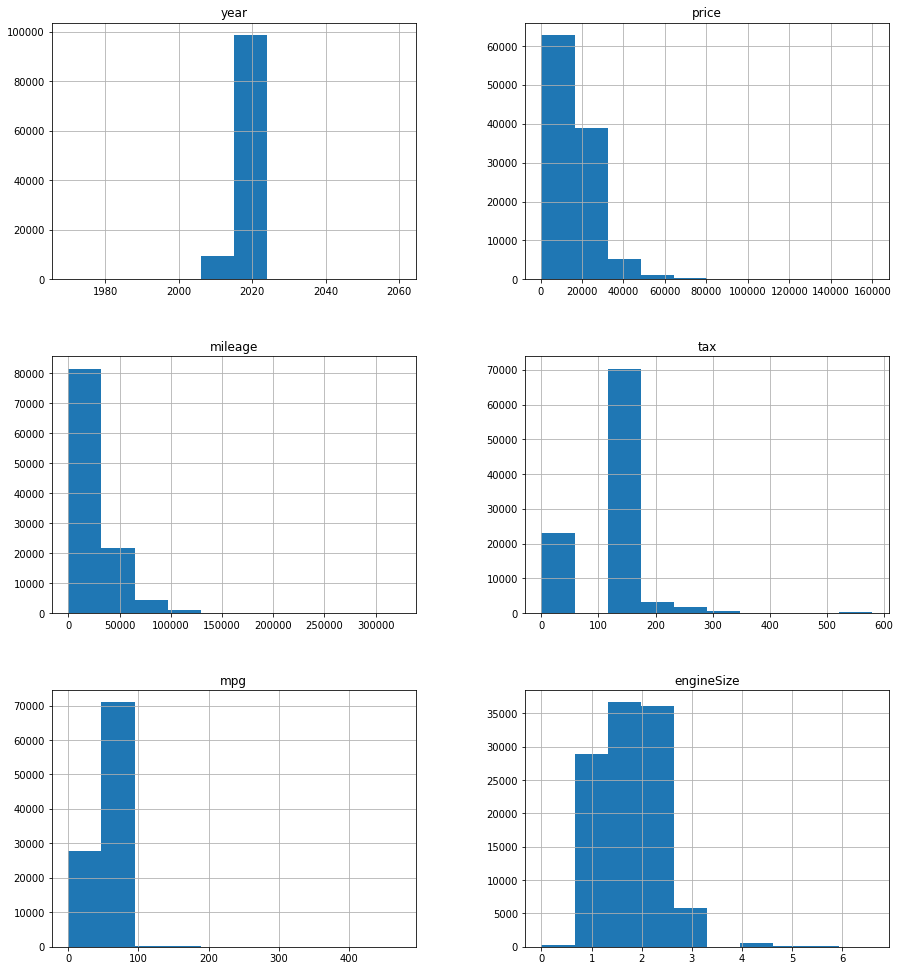

In [5]:
df.hist(figsize=(15,17))

Ninguna de las columnas cuenta con distribución normal, todas se encuentran sesgadas. Por lo mismo voy a utilizar un StandardScaler para poder volver la distribución normal.

<AxesSubplot:>

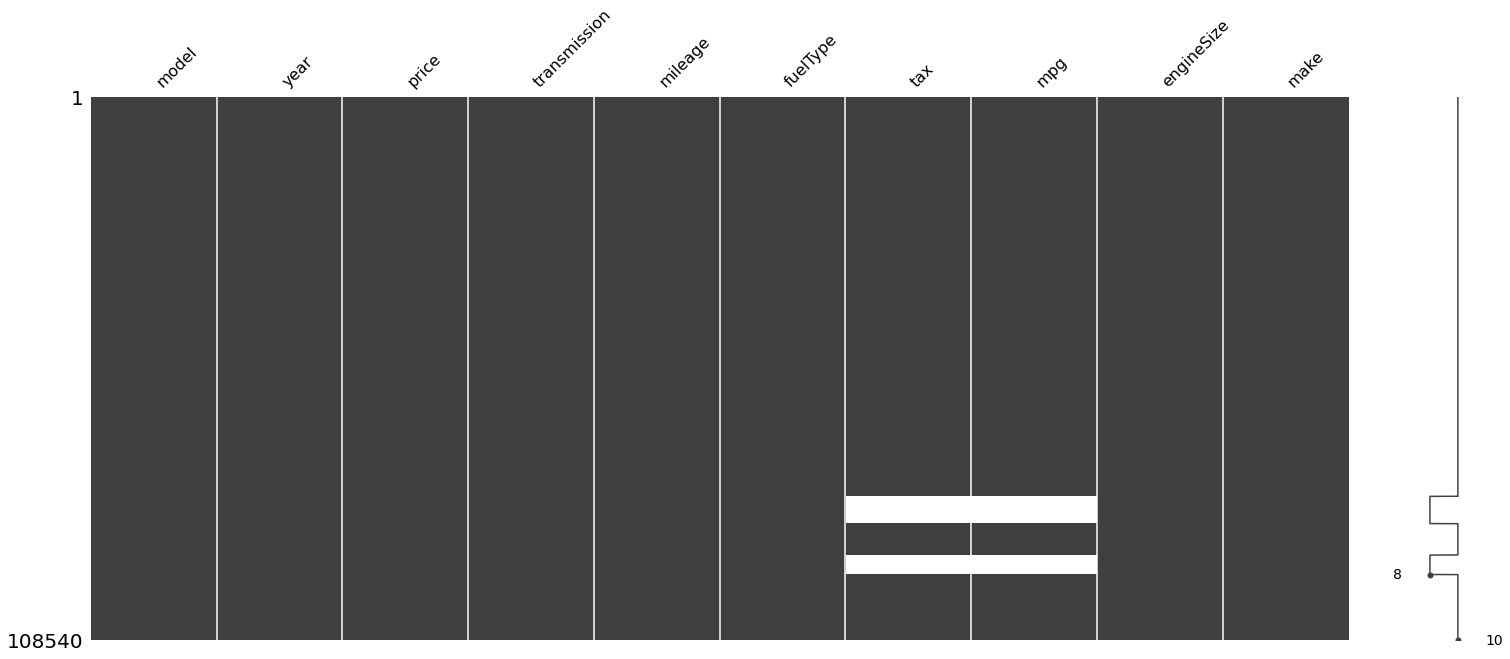

In [6]:
import missingno as msno
msno.matrix(df)

Confirmamos la sospecha que los missing values están relacionados, entre ambas columnas. El KNN imputer se puede utilizar cuando existen datos faltantes que están relacionados entre sí. Podríamos simplemente aplicar un mean/median/mode imputer, pero sería menos óptimo para el modelo.

# Dividir las X's y la Y

Quitamos la variable model, dado a que cuenta con numerosos modelos. El problema con esto es que al momento de hacer split la data, corremos riesgo que algunos modelos se encuentren solo en el training set y otros solo en el testing set. Esto puede dar problema al hacer los predictions, ya que no existirían los thetas necesarios para lidiar con los modelos foráneos.

In [7]:
y = df['price'].copy()
df_2 = df.drop(['price','model'], axis=1) #dejar solo las variables X

### Splitting Data
Separamos el dataset en 70% training y 30% testing, ponemos un random state para reproducibilidad y ponemos el parámetro shuffle como *True*  para que haga shuffle la data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_2, y, test_size=0.3, random_state=20, shuffle=True)

Separamos las columnas categóricas con las númericas

In [9]:
num_col = df_2.select_dtypes(include='number').columns
cat_col = df_2.select_dtypes(exclude='number').columns

In [10]:
cat_col

Index(['transmission', 'fuelType', 'make'], dtype='object')

# Pipelines
Utilizamos pipeline poder aplicar one hot encoding a las categóricas (hace dummify las variables para poder representarse en números y que el modelo de machine learning logre procesarlo), KNN imputer para las dos columnas númericas que tienen NA's, y finalmente un Normalize normalizar la data númerica

### Por qué utilizamos normalize y no standard scaler?
Sabemos que la mayoría de la data no tiene una forma de campana Gaussiana, por lo cual es más adecuado utilizar el Normalizer. Si la data tuviera una distribución normal, hubieramos utilizado el Standard Scaler

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

cat_pipeline = Pipeline([
        ('oh_enc', OneHotEncoder())
    ])

num_pipeline = Pipeline([
        ('knn_imputer', KNNImputer()),
        ('normalize_data', Normalizer())
    ])


El full pipeline contiene los dos pipelines, como también las columnas objetivo a las que se van a aplicar las transformaciones

In [12]:
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
        ("cat", cat_pipeline, cat_col),
        ("num", num_pipeline, num_col)
    ])

In [13]:
X_train_processed = full_pipeline.fit_transform(X_train)
print(X_train_processed.shape)

(75978, 23)


In [14]:
X_test_processed = full_pipeline.fit_transform(X_test)
print(X_test_processed.shape)

(32562, 23)


# Models
Aplicaremos varios modelos, los modelos serán entrenados con el *X_train_processed* set. Después se evaluará la métrica *mean absolute error* sacando las predicciones que saque el modelo con el input de *X_test_processed* y comparándolas con el *y_test*.

## Linear Regression
Ponemos *fit_intercept=True* para utilizar el intercepto en los cálculos, y ponemos *n_jobs=-1* para que el modelo utilice todos los núcleos de la computadora al procesar la información.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression(fit_intercept=True, n_jobs=-1)

In [16]:
lin_reg.fit(X_train_processed, y_train)
y_test_pred = lin_reg.predict(X_test_processed)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_test_pred))

Mean Absolute Error: 3438.030372827222


El error absoluto está alto, pero hay que analizar los demás modelos para ver si se encuentra relativamente alto o bajo.

## Decision Tree Regressor
El parámetro de *splitter* sirve para escoger de qué manera se divide el árbol. Normalmente se hace con el método *best* que sería por medio del coeficiente gini que se establecen las divisiones. Sin embargo, existe la opción de hacerlo random puesto que a veces es mejor un método totalmente aleatorio para poder utilizar en la regresión del decision tree. La opción de *max_depth* significa qué tan profundo puede ser el árbol / cuántos niveles puede tener. Dejamos un intervalo de 5,10,15 porque si incrementamos la profundidad corremos riesgo a que el decision tree haga overfit. Finalmente el *min_samples_leaf* se refiere a la cantidad de observaciones que deben de estar presentes en el leaf node para poder considerarse un leaf node.
El *random_state* se le puede pasar cualquier número, simplemente es para objetivos de reproducibilidad del modelo. El *criterion* lo dejamos como *mae* que es Mean Absolute Error. Nuestra métrica de decisión de modelo es *Mean Absolute Error* por lo que es adecuado utilizar el mismo. El *CV* se refiere a la cantidad de cross-validations o k-folds que deseamos realizar, lo mantenemos en 3 por temas de tiempo y poder computacional. *Verbose* con valor de 1, como lo dice en la documentación de sklearn despliega: "the computation time for each fold and parameter candidate is displayed". *n_jobs* con valor -1 es para que el modelo utilice todos los procesadores de la computadora al momento de procesar el modelo. *return_train_score* lo dejamos como True, sin embargo esto solo se refleja cuando uno saca *cv_results* para que incluya los training scores.

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
param_grid = [ {
                'splitter': ['best','random'],
                'max_depth': [5,10,15], 'min_samples_leaf': [3, 10, 12]
}
             ]

# create instance
dtree_r = DecisionTreeRegressor(random_state=20, criterion='mae')

# search for best solution from combinations using a defined score function
grid_search = GridSearchCV(dtree_r, param_grid, cv=3,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           verbose=1,n_jobs=-1)

grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeRegressor(criterion='mae', random_state=20),
             n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 15],
                          'min_samples_leaf': [3, 10, 12],
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [18]:
dtree_best = grid_search.best_estimator_
dtree_best

DecisionTreeRegressor(criterion='mae', max_depth=15, min_samples_leaf=10,
                      random_state=20)

In [19]:
grid_search.best_score_

-2501.431243254626

Este modelo es el que ha tenido mejor performance que los demás, pero tenemos que ver el resto para decidir el modelo a utilizar al final.

## AdaBoostRegressor
El método de boosting, se refiere a la forma de entrenar modelos de una manera secuencial. Es decir, que va aprende a base de las etapas anteriores. Corrigiendo los errores de los procesos anteriores para tener un modelo más óptimo. Boosting incluye varias etapas de training, y al final se utiliza un group weighted voting para clasificar/hacer regressions. El *learning_rate* en términos simples, detalla qué tan rápido o lento aprende el modelo. Un valor más cercano a 1 aprende más rápido, y si es más alejado de 1 aprende más lento. Los *n_estimators* se refiere al número de sequential trees que se realizarán en el modelo. (Se refiere a árboles ya que el default estimator del modelo es decision tree. El parámetro de *loss* simplemente detalla cómo va a penalizar los errores del modelo, linear siendo el más permisivo y exponential el que más penaliza. El *random_state* se le puede pasar cualquier número, simplemente es para objetivos de reproducibilidad del modelo. El *CV* se refiere a la cantidad de cross-validations o k-folds que deseamos realizar, lo mantenemos en 3 por temas de tiempo y poder computacional. *Verbose* con valor de 1, como lo dice en la documentación de sklearn despliega: "the computation time for each fold and parameter candidate is displayed". *n_jobs* con valor -1 es para que el modelo utilice todos los procesadores de la computadora al momento de procesar el modelo. *return_train_score* lo dejamos como True, sin embargo esto solo se refleja cuando uno saca *cv_results* para que incluya los training scores.

In [20]:
from sklearn.ensemble import AdaBoostRegressor
param_grid = [ {
                'learning_rate': [0.001,0.1,1],
                'n_estimators': [50,100],
                'loss': ['linear','squared','exponential']
}
             ]
# create instance
ada_r = AdaBoostRegressor(random_state=20)

# search for best solution from combinations using a defined score function
grid_search = GridSearchCV(ada_r, param_grid, cv=3,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           verbose=1,n_jobs=-1)

grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\hansr\Documents\UFM\A4_S7\Machine_Learning_Models\mlm_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ -4177.7550008   -4177.20038914             nan             nan
  -4177.8342197   -4178.30321437  -4210.04460233  -4333.73436701
             nan             nan  -4061.60551693  -4282.17852806
  -7368.35461623  -9891.83593348             nan             nan
  -8134.38026669 -11445.28419913]
  warnings.warn(
C:\Users\hansr\Documents\UFM\A4_S7\Machine_Learning_Models\mlm_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [ -4172.61745983  -4173.24118387             nan             nan
  -4172.17243076  -4172.64887222  -4196.79373248  -4316.18856614
             nan             nan  -4056.64142396  -4270.34407869
  -7358.76225475  -9885.23970936             nan             nan
  -8141.53424871 -11441.92992414]
  warnings.warn(


GridSearchCV(cv=3, estimator=AdaBoostRegressor(random_state=20), n_jobs=-1,
             param_grid=[{'learning_rate': [0.001, 0.1, 1],
                          'loss': ['linear', 'squared', 'exponential'],
                          'n_estimators': [50, 100]}],
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [21]:
ada_best = grid_search.best_estimator_
ada_best

AdaBoostRegressor(learning_rate=0.1, loss='exponential', random_state=20)

In [22]:
grid_search.best_score_

-4061.6055169251717

Este modelo ha sido el peor de los que llevamos hasta ahorita, ya que tiene el Mean Absolute Error más alto.

## GradientBoostRegressor
El *random_state* se le puede pasar cualquier número, simplemente es para objetivos de reproducibilidad del modelo. El parámetro *sub_sample* lo dejamos en 0.8, si el valor es menor a cero hace que el modelo reduzca variance/overfitting. *Max_features* lo establecemos como 7, puesto que nuestro dataset simplemente tiene 8 features. Dejamos el número más bajo que el total de features para poder reducir los features más relevantes al modelo.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_r = GradientBoostingRegressor(random_state=20, subsample=0.8, max_features=7)

gradient_r.fit(X_train_processed, y_train)
y_test_pred = gradient_r.predict(X_test_processed)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_test_pred))

Mean Absolute Error: 2894.147156389215


El modelo tiene un performance similar al decision tree regressor, por lo que estos dos han sido los mejores hasta ahorita.

## KNN Neighbours Regressor 
El modelo trabaja con la metodología de KNN neighbours, donde las predicciones son realizadas con los vecinos a los que se encuentra más cercano el valor de predicción. El parámetro de *weights* puede tomar forma como uniform, donde toma en cuenta los pesos de todos los neighbors de igual manera, o distance que mientras más cercano sea el neighbor va a tener más influencia que los que se encuentren más lejos. El *algorithm* lo dejamos en auto, el modelo escoge entre *kd_tree*, *ball_tree* o *brute*. Son varios algoritmos que utiliza el modelo y dependiendo de los valores que se le pasen en la función de *fit*, escoge el más apropiado. El *CV* se refiere a la cantidad de cross-validations o k-folds que deseamos realizar, lo mantenemos en 3 por temas de tiempo y poder computacional. *Verbose* con valor de 1, como lo dice en la documentación de sklearn despliega: "the computation time for each fold and parameter candidate is displayed". *n_jobs* con valor -1 es para que el modelo utilice todos los procesadores de la computadora al momento de procesar el modelo. *return_train_score* lo dejamos como True, sin embargo esto solo se refleja cuando uno saca *cv_results* para que incluya los training scores.

In [24]:
from sklearn.neighbors import KNeighborsRegressor
param_grid = [ {
                'weights': ['uniform','distance']      
}
             ]
# create instance
knn_r = KNeighborsRegressor(algorithm='auto')

# search for best solution from combinations using a defined score function
grid_search = GridSearchCV(knn_r, param_grid, cv=3,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           verbose=1,n_jobs=-1)

grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid=[{'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [25]:
knn_best = grid_search.best_estimator_
knn_best

KNeighborsRegressor(weights='distance')

In [26]:
grid_search.best_score_

-3109.4806694108515

# Conclusión
El modelo con mejor performance de los demostrados anteriormente es *DecisionTreeRegressor* con un *MAE* de 2,501. Se podría experimentar más a fondo con los demás modelos y parámetros, pero por temas de poder computacional y tiempo nos vamos a quedar con este modelo. Previo a la finalización de este notebook, probé los GridSearchCV con más parámetros en los demás modelos pero se tardaba demasiado en procesar los resultados, incluso horas y el modelo no había finalizado.